# Introducción a las redes RNN-LSTM 
### Análisis unidimensional de series de tiempo (1 paso)

## Contenido
### 1. Instalando 'yfinance' y usándolo para importar datos del Bitcoin (utilizando Ticker y get_data_yahoo).
### 2. Prueba para importar múltiples datos (opcional).
### 3. Creación y explicación de la función "univariate_data()" para la preparación de datos.

### *Importando paquetes:*

In [2]:
#RNN
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
#Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
#Data managing
import numpy as np
import os
import pandas as pd

#Setting figure size
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

### *Instalando yfinance:*

In [3]:
#installing yfinance (Colab)
!pip install yfinance
#pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3MB 8.5MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=8f622a7e79276948b86fc0baa4c54f5c1b77b10bacb849d2af91c81549ad4663
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


### *Importando y visualizando datos del bitcoin:*


In [44]:
import yfinance as yf

from pandas_datareader import data as pdr

yf.pdr_override() # <== that's all it takes :-)

#Univariate time series
#One way - get_data_yahoo:
btc_usd = pdr.get_data_yahoo("BTC-USD")
print(type(btc_usd))
btc_usd.head()
#btc_usd.sort_index(ascending=False).head()

#NOTE: Check that index is date by default

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


## (Opcional):
La siguiente celda se puede omitir pues solo muestra la aplicación de unos métodos para series de tiempo univariadas (usando Ticker) y como importar series de tiempo multivariadas:

In [ ]:
###NOTE: minimum interval: 1 minute
#------------------------
#Univariate time series
#------------------------
btc_usd_T = yf.Ticker("BTC-USD")
#type(btc_usd)
#Exploring some methods
#btc_usd.info
#btc_usd.actions
#btc_usd.financials
#btc_usd.history(period="max")
#btc_usd.calendar
#### valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
#btc_usd.history(period="2d",interval="1m") 

#-------------------------
#Multivariate time series
#-------------------------
starDate="2017-01-01" #year-month-day
endDate="2017-04-30"
data = pdr.get_data_yahoo("BTC-USD ETH-USD", start=starDate, end=endDate)
#print(data)
#print(data["Adj Close"])
#print(type(data["Adj Close"]["BTC-USD"]))
#print(data["Adj Close"]["BTC-USD"])
dataTickers = yf.Tickers('BTC-USD ETH-USD')
#print(dataTickers.tickers["BTC-USD"].info)
#print(dataTickers.tickers["ETH-USD"].history(period="1mo"))

[*********************100%***********************]  2 of 2 completed


## Registros diarios (uno por día)
Como se puede ver hay se tienen 2420 registros diarios del Bitcoin (desde el 2014 hasta la fecha):

In [ ]:
btc_usd.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2424.000000,2424.000000,2424.000000,2424.000000,2424.000000,2.424000e+03
mean,7264.383626,7467.329574,7053.783424,7286.774635,7286.774635,1.211044e+10
std,11168.437228,11510.882994,10801.951278,11211.832933,11211.832933,1.907698e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,457.368492,462.603989,453.210510,457.509499,457.509499,6.820313e+07
50%,4170.250000,4316.177002,4061.894775,4178.330078,4178.330078,3.917430e+09
75%,9108.849854,9275.408203,8860.103027,9122.761963,9122.761963,1.810460e+10
max,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


## (Hiper)Parámetros para la red LSTM

In [45]:
#Data load params
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = int(len(btc_usd)*0.8)
#print(TRAIN_SPLIT)
#print(type(TRAIN_SPLIT))
#print(2424*0.8)

#LSTM params
EVALUATION_INTERNAL = 200
EPOCHS = 4
PATIENCE = 5

#Seeding
SEED = 13
tf.random.set_seed(SEED)


## Función de preparación de datos univariados de entrenamiento (*candidata a exportar*)

In [46]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  ''' dataset: Array containing the whole time series (stadarized or not)
      start_index: index from where data start to analize
      end_index: final index to take data. None is to take all data
      history_size: window size to create sequence (and then used to predict)
      target_size: size of data to predict
  '''
  hist = [] #hist = history
  targets = [] 

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    #window = window of time
    window = range(i-history_size,i) #it balances the start_index = start_index + history_size made above
    #print(window,i)
    #print(window)
    #Reshape hist from (history_size,) to (history_size,1)
    hist.append(np.reshape(dataset[window], (history_size, 1))) #len(dataset[window]) = history_size
    #print(hist)
    targets.append(dataset[i+target_size-1])
  return np.array(hist), np.array(targets)

Mirando como trabaja la función univariate_data haciendo una prueba:

In [18]:
test = np.arange(0,10)
#print(type(test))
#print(test)
#print(test[range(0,4)]) #equivalent to dataset[window]
#print(np.reshape(test[range(0,4)], (4,1)))
#print(test.shape[])
#x,y = univariate_data(dataset=test, start_index=0, end_index=8, history_size=4,target_size=1)
#print(x)
#print(y)
#a = range(-5,5)

### Seleccionando los datos de la serie de tiempo a analizar

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Adj Close, dtype: float64


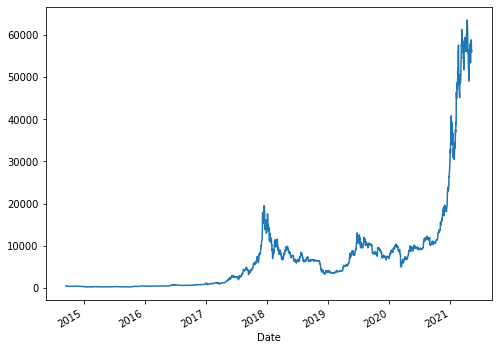

[  457.33401489   424.44000244   394.79598999 ... 58232.31640625
 55859.796875   56128.421875  ]


In [47]:
#Extrating data from data frame:
uni_data = btc_usd['Adj Close']
print(uni_data.head())

#-----Indexing (If index is not 'Date'): I THINK IT IS NOT NECCESARY
#print(uni_data.index)
#uni_data.index = pd.to_datetime(uni_data.index,format='%Y-%m-%d')
#print(uni_data.index)
#uni_data.index = btc_usd['Date']
#print(uni_data.head())

#Plotting
uni_data.plot()
plt.show()

#Extracting data as array
uni_data = uni_data.values
print(uni_data)

## Estandarización (Crear una función *Candidata a exportar*)

In [50]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
#print(uni_train_mean)
uni_data = (uni_data - uni_train_mean)/uni_train_std

## Creando los datos para la predicción a 1 paso

In [56]:
#Defining history and target size
uni_past_history = 20
uni_future_target = 0 #I DONT KNOW WHY 0 AND NOT 1

#Creating training data
x_train_uni, y_train_uni = univariate_data(dataset = uni_data, start_index = 0, 
                                           end_index = TRAIN_SPLIT, history_size=uni_past_history,
                                           target_size = uni_future_target)

#Creating validation (for prediction) data
x_val_uni, y_val_uni = univariate_data(dataset = uni_data, start_index = TRAIN_SPLIT,
                                       end_index = None, history_size = uni_past_history,
                                       target_size = uni_future_target)

#Checking shape
print(uni_data.shape)
print(x_train_uni.shape)
print(y_train_uni.shape)

(2425,)
(1920, 20, 1)
(1920,)


## Modificando el formato de los datos para el uso de RNN-LSTM

In [ ]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle()

Seleccionando las características (features): NO ANALIZADO AÚN

                  Open        High   Adj Close
Date                                          
2014-09-17  465.864014  468.174011  457.334015
2014-09-18  456.859985  456.859985  424.440002
2014-09-19  424.102997  427.834991  394.795990
2014-09-20  394.673004  423.295990  408.903992
2014-09-21  408.084991  412.425995  398.821014
DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2021-05-02', '2021-05-03', '2021-05-04', '2021-05-05',
               '2021-05-06', '2021-05-07', '2021-05-08', '2021-05-09',
               '2021-05-10', '2021-05-11'],
              dtype='datetime64[ns]', name='Date', length=2425, freq=None)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc85c66d10>,
      dtype=object)

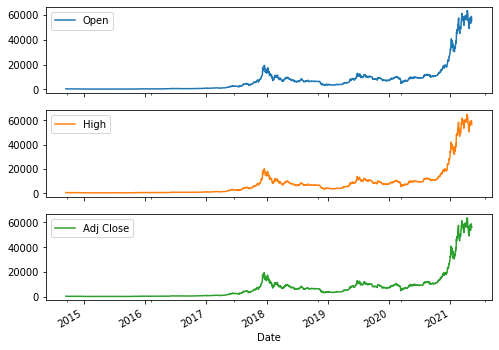

In [10]:
#Selecting features:
features_considered = ['Open', 'High', 'Adj Close']
features = btc_usd[features_considered]
#print(type(features))
print(features.head())
print(features.index)

#-----If index is not 'Date':
#features.index = btc_usd['Date']
#print(features.head())

#Plotting
features.plot(subplots=True)

<class 'numpy.ndarray'>
[[  465.86401367   468.17401123   457.33401489]
 [  456.85998535   456.85998535   424.44000244]
 [  424.10299683   427.83499146   394.79598999]
 ...
 [58877.390625   59210.8828125  58232.31640625]
 [58250.87109375 59519.35546875 55859.796875  ]
 [55665.359375   56385.7265625  55909.1640625 ]]


TypeError: ignored

ddd

In [ ]:
dataset =

Standarized

## Cosas pendientes:
1. Uso de redes LSTM (unidimensional) para hacer predicción 1 paso y multipaso.
2. Detección de series correlacionadas.
3. Analizar otras series (S&P500, JPMorgan, Gold, Apple, etc.)
4. Uso de redes LSTM (multidimensional) para hacer predicción 1 paso y multipaso.

## Bibliografía

### Redes RNN-LSTM (cuaderno).
1. [Introducción a Keras LSTM para series de tiempo multivariadas. Montenegro et.al.](https://nbviewer.jupyter.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnrTimes_series_Multivariate.ipynb).
1. A. [Notebook community: Time series forecasting (Ori. English)](https://notebook.community/tensorflow/docs-l10n/site/en-snapshot/tutorials/structured_data/time_series).
1. B. [Keras Timeseries Multi-Step Multi-Output](https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output).

### Yahoo Finance (datos importados).
2. [Yahoo Finance API – A Complete Guide](https://algotrading101.com/learn/yahoo-finance-api-guide/)
3. [yfinance Library – A Complete Guide](https://algotrading101.com/learn/yfinance-guide/)
4. [yfinance documentation](https://pypi.org/project/yfinance/)

### Cuadernos de referencia.
5. [Predicción de acciones usando análisis multivariado (repo)
](https://github.com/ninja3697/Stocks-Price-Prediction-using-Multivariate-Analysis). 
6. [Serie de tiempo multivariadas para predicción de precios en Python](https://www.relataly.com/stock-market-prediction-with-multivariate-time-series-in-python/1815/). 
7. [Conversión de datos (clima)](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/).
8. [Predicción en series de tiempo multivariadas (clima)](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/).
### Libro
9. [François Chollet - Deep Learning with Python](https://b-ok.lat/s/Deep%20Learning%20with%20Python%20Fran%C3%A7ois%20Chollet).
### Artículo
10. [Stock Price Prediction Using CONVOLUTIONAL Neural Networks on a Multivariate Timeseries. Article](https://www.researchgate.net/publication/338477393_Stock_Price_Prediction_Using_Convolutional_Neural_Networks_on_a_Multivariate_Timeseries). 
[]().


##Links sobre criptomonedas (bitcoin especialmente)
https://unperiodico.unal.edu.co/pages/detail/criptomonedas-una-herramienta-riesgosa-pero-de-uso-inminente/

https://repositorio.udesa.edu.ar/jspui/bitstream/10908/16022/1/%5BP%5D%5BW%5D%20T.%20M.%20AyPP.%20Lojo%20M%C3%A1rquez%2C%20Tamara%20In%C3%A9s.pdf  (cap2 c, cap3 ii, cap4)

https://www.daviescoin.io/es/blog/que-determina-el-valor-de-las-criptomonedas

https://www.tekcrispy.com/2018/05/16/que-determina-precio-criptomonedas/

https://repositorio.uniagustiniana.edu.co/bitstream/handle/123456789/845/HurtadoCuellar-AngieDaniela-2019.pdf.pdf?sequence=1 (cap7)
